In [1]:
from torchvision import datasets
import numpy as np
from matplotlib import pyplot as plt

(28, 28)


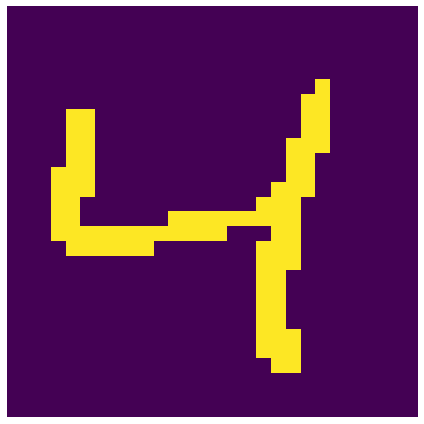

In [2]:
mnist = datasets.MNIST('data', train=True, download=True)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

image_pil = mnist[2][0]
image_np = np.asarray(mnist[2][0]) # To undo: im = PIL.Image.fromarray(numpy.uint8(I))

image_np[image_np>100] = 255
image_np[image_np<100] = 0


ax.imshow(image_np)
ax.axis('off')
plt.tight_layout()

print(image_np.shape)

In [3]:
def weights(img):
    channel = 1
    n_row, n_col = img.shape
    
    N = n_row*n_col
    W = np.zeros((N,N))
    
    r = 2
    sigma_I = 0.2
    sigma_X = 1
    
    for row_count, row in enumerate(img):
        for col_count, v in enumerate(row):
            index = row_count * n_col + col_count

            search_w = r * 2 + 1
            start_row = row_count - r
            start_col = col_count - r

            for d_row in range(search_w):
                for d_col in range(search_w):
                    new_row = start_row + d_row
                    new_col = start_col + d_col
                    dst = (new_row - row_count) ** 2 + (new_col - col_count) ** 2
                    if 0 <= new_col < n_col and 0 <= new_row < n_row:
                        if dst >= r ** 2:
                            continue

                        cur_index = int(new_row * n_col + new_col)

                        F = img[row_count, col_count] - img[new_row, new_col]
                        if channel == 3:
                            F_diff = F[0]**2 + F[1]**2 + F[2]**2  
                        else:
                            F_diff = np.abs(F) #**2

                        w = np.exp(-((F_diff / (sigma_I ** 2)) + (dst / (sigma_X ** 2))))
                        W[index, cur_index] = w

    return W

W - min 0.0, max 1.0, avg 0.0035298685414655224


/tmp/ipykernel_5239/250493885.py:31: RuntimeWarning: overflow encountered in ubyte_scalars
  F = img[row_count, col_count] - img[new_row, new_col]


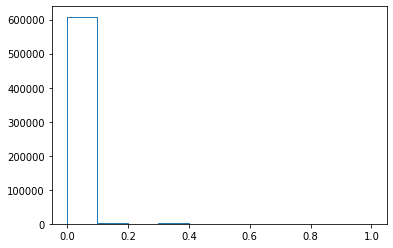

[608472   2584      0   2816      0      0      0      0      0    784]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


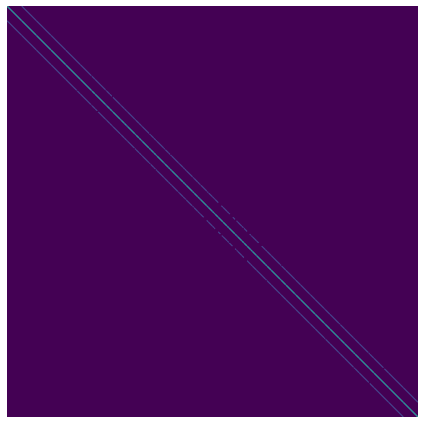

In [4]:
W = weights(image_np)

print(f'W - min {np.min(W)}, max {np.max(W)}, avg {np.average(W)}')

# Shows the bins of the outputs for it...
counts, bins = np.histogram(W)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))
ax.imshow(W)
ax.axis('off')
plt.tight_layout()

L      - min -0.36787944117144233, max 2.0128588976322206, avg 4.320552430796046e-19
L_symm - min -0.20052592135731548, max 0.6680893350877163, avg 1.4725745843577905e-06


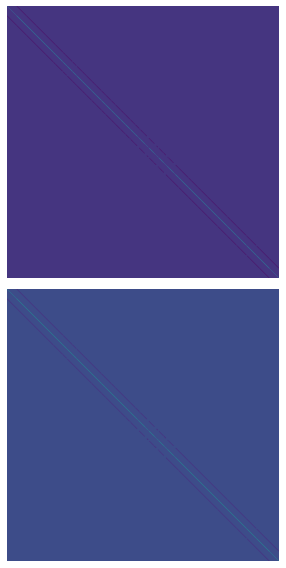

In [5]:
d = np.sum(W, axis=0)
D = np.diagflat(d)

d_sqrt_inv = np.power(np.sqrt(d),-1)
D_sqrt_inv = np.diagflat(d_sqrt_inv)

L = D-W
L_symm = D_sqrt_inv @ (D-W) @ D_sqrt_inv

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))
ax[0].imshow(L)
ax[1].imshow(L_symm)
for a in ax:
    a.axis('off')
plt.tight_layout()

print(f'L      - min {np.min(L)}, max {np.max(L)}, avg {np.average(L)}')
print(f'L_symm - min {np.min(L_symm)}, max {np.max(L_symm)}, avg {np.average(L_symm)}')

In [6]:
from scipy.linalg import eigh

# import sys
# sys.path.append("../")
# from nc import NormalizedCuts

# Node = NormalizedCuts(symm_norm_L=True)

# turns despite requesting the correct order it is wrong :)


# TODO: in general
# Lsymm vs L
# eigs, eigh and a few others probably... also sigma for eigs?
# TODO: for this part
# y = D_inv_sqrt * z
# index = np.argsort(lam)
# smallest = y[:, index[1]] # Does this line make any sense at all??? Or is it wrong..


# Current learnings:
# the order is different every time, despite an option which is 'which' = Smallest real.. (more the method used and not the actual thing..)
# changing parameters of the weights (sigma X and sigma I) can lead to zero convergence with ARPACK
# try LAPACK based solvers??

# lam_l, z_l = linalg.eigsh(L, which='SA')
lam_l, z_l = eigh(L)
index_l = np.argsort(lam_l)
print(lam_l.real)
print(index_l)

print('\n')

# lam_lsymm, z_lsymm = linalg.eigsh(L_symm, which='SA')
lam_lsymm, z_lsymm = eigh(L_symm)
index_lsymm = np.argsort(lam_lsymm)
print(lam_lsymm.real)
print(index_lsymm)

[-2.93605571e-13  9.76827689e-12  1.78254224e-03  2.56699525e-03
  3.22216482e-03  1.19904615e-02  1.24131635e-02  1.44312076e-02
  1.91747349e-02  2.18592085e-02  2.86111386e-02  3.45038950e-02
  3.87782645e-02  4.21847391e-02  4.76777262e-02  5.48131473e-02
  5.54172424e-02  6.38151440e-02  6.90378351e-02  7.70390665e-02
  8.12835143e-02  9.59955402e-02  1.04181133e-01  1.06109077e-01
  1.10219101e-01  1.17210193e-01  1.19676377e-01  1.25926580e-01
  1.29592539e-01  1.34371569e-01  1.37357763e-01  1.58571421e-01
  1.71690141e-01  1.76378159e-01  1.77988822e-01  1.82044939e-01
  1.86244157e-01  1.93775027e-01  1.96162665e-01  1.96310545e-01
  2.03357556e-01  2.15042679e-01  2.29079019e-01  2.29354591e-01
  2.52708353e-01  2.60426894e-01  2.66222649e-01  2.68393402e-01
  2.73636480e-01  2.80112852e-01  2.86761526e-01  2.88169910e-01
  2.94839630e-01  3.03722060e-01  3.09731660e-01  3.25820208e-01
  3.35272746e-01  3.43974491e-01  3.49406644e-01  3.52146240e-01
  3.59644703e-01  3.62237

In [7]:
y_l = D_sqrt_inv @ z_l
y_lsymm = D_sqrt_inv @ z_lsymm

In [8]:
def plot_6(input, index, vals):
    fig, ax = plt.subplots(nrows=6, sharex=True, sharey=True, figsize=(12, 12))

    for i, a in enumerate(ax):
        a.axis('off')
        a.imshow(np.reshape(input[:, i].real, (28,28)))
        a.set_title(f'{index[i]} / {np.min(input[:, i].real)} / {np.max(input[:, i].real)} / val {vals[i].real}')
    plt.tight_layout()

non symmetric


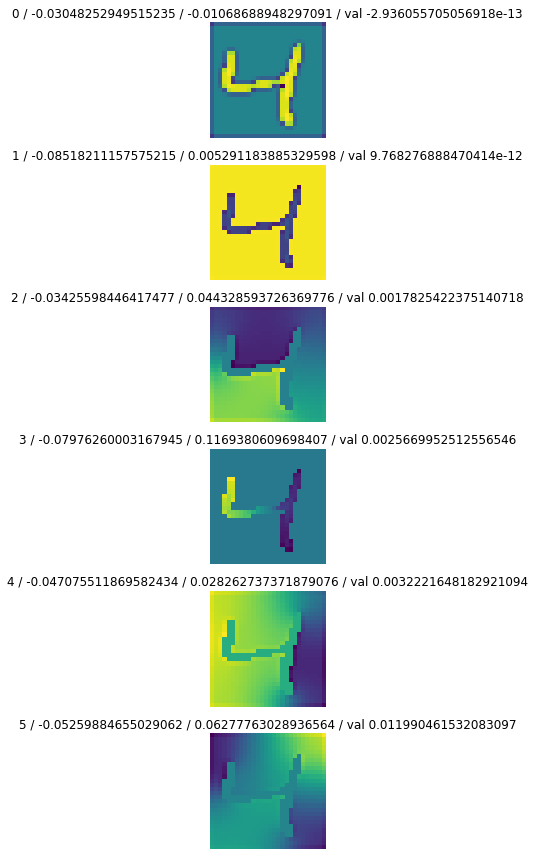

In [9]:
plot_6(y_l, index_l, lam_l)
print('non symmetric')

symmetric


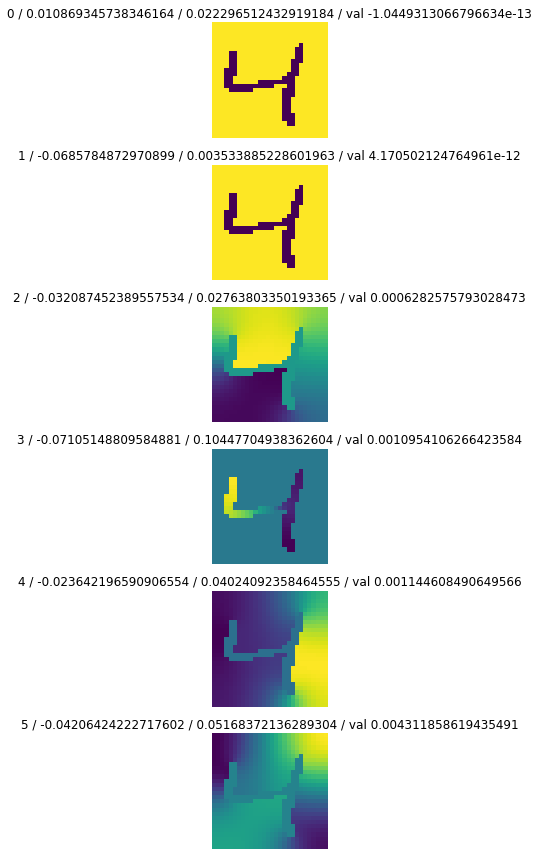

In [10]:
plot_6(y_lsymm, index_lsymm, lam_lsymm)
print('symmetric')

In [11]:
def partition_by_step(input, D, W):
    step = 50
    pos = input.copy()
    max_value = pos.max()
    min_value = pos.min()
    setp = (max_value - min_value) / step
    dict = {}
    for i in range(1, step):
        partition = (min_value + i * setp)
        temp_pos = pos < partition


        k = (np.sum(W[temp_pos])) / (np.sum(D))
        b = k / (1 - k)

        y = temp_pos.astype('float64') * 2 - b * (temp_pos == False).astype('float64') * 2

        ncut = (y @ (D - W) @ y.T) / (y @ D @ y.T)
        dict[i] = ncut

    min_partition = min_value + min(dict, key=dict.get) * setp
    pos[pos >= min_partition] = 255
    pos[pos < min_partition] = 0

    pos = pos.reshape((28, 28))

    return pos.astype('uint8')

In [12]:
def partition_by_zero(input):
    input = input.reshape((28,28)).astype('float64')   
    input[input>0] = 255
    return input.astype('uint8')

In [13]:
def partition_by_avg(input):
    return partition_by_zero(input - np.average(input))

In [14]:
def partition_by_avg_nocut(input):
    return input - np.average(input)

l     / -2.38509912412106 / 0.14815314878922875
lsymm / -1.9201976443185171 / 0.09894878640085496


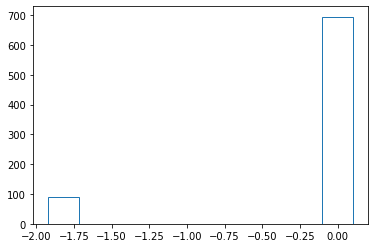

[ 89   0   0   0   0   0   0   0   0 695]
[-1.92019764 -1.718283   -1.51636836 -1.31445372 -1.11253907 -0.91062443
 -0.70870979 -0.50679514 -0.3048805  -0.10296586  0.09894879]


In [15]:
chosen_index = 1

resize_l = y_l[:, chosen_index].real * 28
resize_lsymm = y_lsymm[:, chosen_index].real * 28

print(f'l     / {np.min(resize_l)} / {np.max(resize_l)}')
print(f'lsymm / {np.min(resize_lsymm)} / {np.max(resize_lsymm)}')

# Shows the bins of the outputs for it...
counts, bins = np.histogram(resize_lsymm)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)

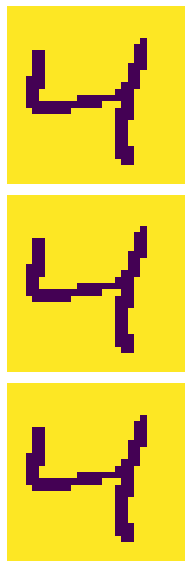

In [16]:

y_l_step = partition_by_step(y_l[:, index_l[chosen_index]], D, W)
y_l_zero = partition_by_zero(y_l[:, index_l[chosen_index]])
y_l_avg = partition_by_avg(y_l[:, index_l[chosen_index]])

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(6, 8))
ax[0].imshow(y_l_step)
ax[1].imshow(y_l_zero)
ax[2].imshow(y_l_avg)
for a in ax:
    a.axis('off')
plt.tight_layout()

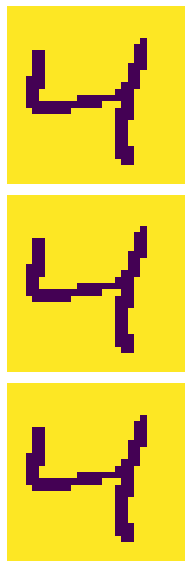

In [17]:
y_lsymm_step = partition_by_step(y_lsymm[:, index_lsymm[chosen_index]], D, W)
y_lsymm_zero = partition_by_zero(y_lsymm[:, index_lsymm[chosen_index]])
y_lsymm_avg = partition_by_avg(y_lsymm[:, index_lsymm[chosen_index]])


fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(6, 8))
ax[0].imshow(y_lsymm_step)
ax[1].imshow(y_lsymm_zero)
ax[2].imshow(y_lsymm_avg)
for a in ax:
    a.axis('off')
plt.tight_layout()

In [18]:
# Take Lsymm and do the lossInterp
import torch
import torch.nn as nn

def lech_loss(pred, mask):
    """
    pred is yhat
    mask is y

    _bar is -1,b becoming 0,b
    idealy everything is close to -1,1 actual or 0,1 _bar form

    so instead of classification loss, MSE loss for the application
    """

    # mask should be in format {-1, 1} ideally
    # mask_bar is {0,1} for regression style problem

    mask = mask.reshape((28,28))/255
    pred = pred.reshape((28,28))

    # mask = mask.flatten(-2)#[:,None,:]
    # pred = pred.flatten(-2)#[:,:,None]

    mask_bar = torch.div((mask+1),2) # y_n
    # pred_bar = torch.div((pred+1), 2) # yhat_n convert predicition to {0,1} roughly too
    # goes to 0 if not using above :)
    pred_bar = pred

    relu = nn.ReLU()

    mask_bar = mask_bar.type(pred_bar.dtype)

    loss = torch.matmul((1-mask_bar),(pred_bar+1)**2) + torch.matmul(mask_bar, relu(-pred_bar))
    return torch.mean(loss) # avg across batch I guess

In [19]:
def argmin2(array):
    # O(n) to find second smallest argmin, instead of sorting O(n^2)
    min1 = np.inf
    min2 = np.inf
    min_idx1 = min_idx2 = i = 0
    n = array.shape[0]
    
    for i in range(n):
        x = array[i]
        if x < min1:
            min2 = min1
            min_idx2 = min_idx1
            min1 = x
            min_idx1 = i
        elif x > min1 and x < min2:
            min2 = x
            min_idx2 = i
        i += 1

    return min_idx2

In [20]:
def cut(W):
    W = W.numpy()
    d = W.sum(axis=0)
    D = np.diag(d) 
    
    d2 = np.sqrt(d, where=d>0) # avoid nans and infs using where
    d2 = np.reciprocal(d2, where=d2>0) # avoid nans and infs using where
    D2 = np.diag(d2)

    L_norm = D2 * (D - W) * D2
    
    vals,vectors = eigh(L_norm)
    
    vals, vectors = np.real(vals), np.real(vectors)
    index2 = argmin2(vals)
    ev = vectors[:, index2]
    
    return ev
    

/tmp/ipykernel_5239/250493885.py:31: RuntimeWarning: overflow encountered in ubyte_scalars
  F = img[row_count, col_count] - img[new_row, new_col]


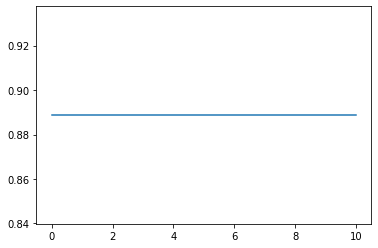

In [24]:
random_count = 3
steps = 10
lerp_weight = 0.05
# criterion = lech_loss
criterion = nn.HingeEmbeddingLoss()

W = weights(image_np)

true_img = (torch.from_numpy(image_np)/255 - 0.5) * 2 # make true -1, 1
true_w = torch.from_numpy(W)

initial = torch.zeros_like(torch.from_numpy(W)) # Random weights, of the correct size

inbetween_weights = initial # Set the initial lerp to the initial random

# TODO: options to solve the interpolate problem
# interpolate the image, and then calculate the weights
# do the reverse, random walk from true towards something else...
# just ReLU it and it should work...

# TODO:
# verify why the eig solver is no longer working for the true output...
# when it *should* be the same as the one above which does work

# TODO:
# compare against the original testLossLinearinterp?

losses = []
outputs = []
for i in range(0, steps):
    inbetween_weights = torch.lerp(inbetween_weights, true_w, lerp_weight) # lerp_weight percent steps towards true weights
    output = cut(inbetween_weights)
    
    out_avg = partition_by_avg_nocut(output)
    out_avg = out_avg.reshape((28,28)) # as true_img isn't flattened
    # print(f'out_avg - min {np.min(out_avg)}, max {np.max(out_avg)}, avg {np.average(out_avg)}')
    loss_1 = criterion(torch.from_numpy(out_avg), true_img)
    
    output = partition_by_avg(output)
    outputs.append(output.reshape((28,28)))
    losses.append(loss_1)
    # loss_2 = criterion(output, true_img*-1)
    
x = np.linspace(0, steps, steps)
plt.plot(x, losses)
plt.show()

In [22]:
import ipyplot
print(len(outputs))
ipyplot.plot_images(images=outputs, img_width=96, max_images=steps)

10


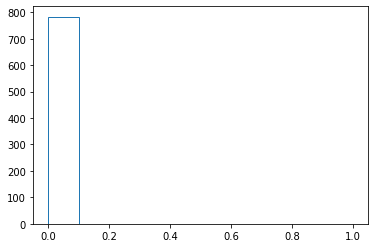

[783   0   0   0   0   0   0   0   0   1]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


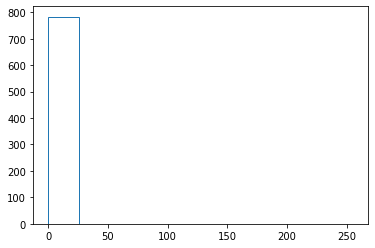

[783   0   0   0   0   0   0   0   0   1]
[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]


In [23]:
ipyplot.plot_images([image_np], img_width=96)


cut_from_final = cut(true_w).reshape(28,28)

# Shows the bins of the outputs for it...
counts, bins = np.histogram(cut_from_final)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)

cut_from_final[cut_from_final>0] = 255
cut_from_final[cut_from_final<0] = 0

# Shows the bins of the outputs for it... after segmenting
counts, bins = np.histogram(cut_from_final)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)

ipyplot.plot_images([cut_from_final], img_width=96)